In [1]:
########################
#
# Excersises
#
########################


### E01: train a trigram language model, i.e. take two characters as an input to predict the 3rd one. Feel free to use either counting or a neural net. Evaluate the loss; Did it improve over a bigram model?


In [1]:
import torch
import matplotlib.pyplot as plt 
import torch.nn.functional as F

import requests 

In [47]:
chars = sorted(list(set((''.join(words)))))  #get unique characters 
stoi = {s:i+1 for i, s in enumerate(chars)}  # map char to int
stoi["."] = 0 
itos = {i:s for s,i in stoi.items()}         # map int to char

In [70]:
# calculate trigram frequencies in Matrix Form 
N = torch.zeros( 27, 27, 27, dtype=int)
b = {}
for w in  words:
    chs =  ['.']  + ['.']  +  list(w) + ['.'] 
    
    for ch1,ch2,ch3 in zip(chs, chs[1:], chs[2:]):
        
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        ix3 = stoi[ch3]
        N[ix1][ix2][ix3] += 1
    

In [71]:
# Convert trigram frequency matrix to probability matrix
P=(N+ 0.0001).float()# adding 1 to prevent probability from being 0 giving infinite loss
P=P/P.sum(1, keepdim=True)
print(P.shape)

torch.Size([27, 27, 27])


In [65]:
P[0][0]

tensor([3.7037e-02, 9.9256e-09, 4.2735e-07, 7.0421e-07, 2.0243e-07, 2.4456e-08,
        2.2726e-06, 2.6314e-06, 6.5488e-08, 3.5600e-08, 1.9999e-06, 6.2111e-07,
        6.3775e-08, 1.2674e-07, 1.2392e-07, 3.8476e-08, 2.1275e-06, 9.0887e-06,
        4.5269e-08, 2.0790e-07, 3.7174e-07, 7.5131e-08, 2.1186e-07, 1.0869e-06,
        2.7776e-06, 7.4294e-08, 3.1949e-07])

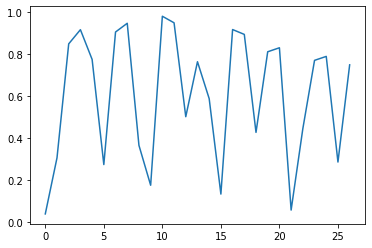

In [72]:
plt.plot(P[0][0].tolist())

In [77]:
# sampling dumb lang  model basesd on probability matrix 
g=torch.Generator().manual_seed(55)
for i in range(20):

  ix1 = 0
  ix2 = 0 
  out = []
  while True:
    p = P[ix1][ix2] 
    
    # print(ix1,ix2)
    ix1=ix2
    ix2 = torch.multinomial(p,num_samples=1,replacement=True, generator=g).item()
    
    out.append(itos[ix2])
    
    if ix2 == 0:
      break
  print(''.join(out))

qwzx.
trexspromoffiqurexzqxqkqqnpadforyssuhihuxxwgwjxjkazulfggowdyxissigh.
zopek.
zyridiffatoff.
g.
j.
b.
lippholuwafwkegaebres.
kyzx.
p.
jujuprquedwazam.
wabelo.
inquolbukwuelyockfqkzaydge.
chrockyzabbfqkqqtpzjaychlogh.
x.
jerkhyngwjw.
w.
jozzoevyeffpphoguyptowsoffgpqffyprjujuvriffkarrirray.
b.
jattowaspegertoxxwk.


In [78]:
# loss calculation for model based on probability materix 
logLikelihood = 0.0
nll = 0
n = 0
for w in  words:
    chs = ['.'] + ['.'] + list(w) + ['.']
    for ch1,ch2,ch3 in zip(chs, chs[1:], chs[2:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        ix3 = stoi[ch3]
        prob = P[ix1][ix2][ix3]
        logprob = torch.log(prob) #multiplication of probabilites same as addition of negative log probabilites
        logLikelihood += logprob
        n += 1  
    nll = -logLikelihood
      
print(f"log {logLikelihood}")
print(f"nll {nll}")
print(f"LOSS nll/n {nll/n}")

log -416811.03125
nll 416811.03125
LOSS nll/n 1.826948642730713


In [79]:
#This model has lower loss compaerd to the bigram probability matrix model

In [ ]:
#Now neural net work approach


In [86]:
#create training set 
xs, ys = [], []
n = 0
for w in words:
    chs = ['.'] + ['.'] + list(w) + ['.']
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        ix3 = stoi[ch3]
        # print(ch1,ch2) be carful with prints and for loops long for loops are very hard to stop ,kernel become un alive 
        xs.append([ix1, ix2])
        ys.append(ix3)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [158]:
W = torch.randn((54,27),requires_grad=True).float()


0 tensor(4.1691, grad_fn=<AddBackward0>)
1 tensor(3.4948, grad_fn=<AddBackward0>)
2 tensor(3.2813, grad_fn=<AddBackward0>)
3 tensor(2.9908, grad_fn=<AddBackward0>)
4 tensor(2.8773, grad_fn=<AddBackward0>)
5 tensor(2.8010, grad_fn=<AddBackward0>)
6 tensor(2.7758, grad_fn=<AddBackward0>)
7 tensor(2.7069, grad_fn=<AddBackward0>)
8 tensor(2.7241, grad_fn=<AddBackward0>)
9 tensor(2.6300, grad_fn=<AddBackward0>)
10 tensor(2.6293, grad_fn=<AddBackward0>)
11 tensor(2.5977, grad_fn=<AddBackward0>)
12 tensor(2.6328, grad_fn=<AddBackward0>)
13 tensor(2.5552, grad_fn=<AddBackward0>)
14 tensor(2.5656, grad_fn=<AddBackward0>)
15 tensor(2.5420, grad_fn=<AddBackward0>)
16 tensor(2.5835, grad_fn=<AddBackward0>)
17 tensor(2.5129, grad_fn=<AddBackward0>)
18 tensor(2.5286, grad_fn=<AddBackward0>)
19 tensor(2.5084, grad_fn=<AddBackward0>)
20 tensor(2.5530, grad_fn=<AddBackward0>)
21 tensor(2.4861, grad_fn=<AddBackward0>)
22 tensor(2.5045, grad_fn=<AddBackward0>)
23 tensor(2.4862, grad_fn=<AddBackward0>)
24

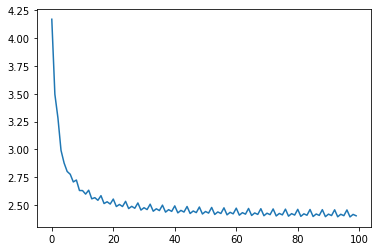

In [159]:
lossi= []

xenc=F.one_hot(xs,num_classes=27).float()
for k in range(100):
    # forward pass
    num=xs.shape[0]
    logits= xenc.view(-1,54)@W
    counts = logits.exp()
     
    probs = counts/counts.sum(1,keepdims=True)
    # loss calculation
    loss = -probs[torch.arange(num),ys].log().mean() +0.01*(W**2).mean() #regularization ie smoothing the weights
    
    # loss=F.cross_entropy(probs,ys) 
    W.grad=None 
    loss.backward()
    print(k,loss)
    lossi.append(loss.data)
    # update
    W.data += -50 * W.grad
plt.plot(lossi)

In [140]:
#achieved lower loss than model that took in single previous charecter in 100 steps